# Linear Trajectory Optimization in Julia
Given a forced linear dynamical system
\begin{align}
\dot{\mathbf{x}} = A \mathbf{x} + B \mathbf{u}
\end{align}
where $\mathbf{x} \in \mathbb{R}^n$, $\mathbf{u} \in \mathbb{R}^m$, $A \in \mathbb{R}^{n \times n}$ and $B \in \mathbb{R}{n \times m}$, we wish to find a trajectory $\mathbf{x}(t)$ from $\mathbf{x}(0) = \mathbf{x}_0$ to $\mathbf{x}(t_f) = \mathbf{x}_f$.

To do so, we discretize the system,
\begin{align}
\mathbf{x}_{k+1} = A_d \mathbf{x}_k + B_d \mathbf{u}_k
\end{align}
where we make the zero-order hold assumption that $\mathbf{u}_k$ is constant over the interval from $k$ to $k + 1$, and where
\begin{align}
\begin{bmatrix}
A_d & B_d \\ \mathbf{0}_{m \times n} & \mathbf{I}_{m \times m} 
\end{bmatrix}
=
\exp \left(
\begin{bmatrix}
A & B \\ \mathbf{0}_{m \times n} & \mathbf{0}_{m \times m} 
\end{bmatrix}
\Delta t
\right)
\end{align}
with $\Delta t$ being the discretization timestep.

We can then write the trajectory optimization as a quadratic program with linear constraints,
\begin{align}
&\mathrm{min} && \|\mathbf{u}\| \\
&\mathrm{s.t.} && \mathbf{x}_{k+1} = A_d \mathbf{x}_k + B_d \mathbf{u}_k \\
&&& \mathbf{x}_0 = \mathbf{x}_0 \\
&&& \mathbf{x}_N = \mathbf{x}_f \\
&&& \|\mathbf{u}_*\| \leq \mathbf{u}_\text{max}.
\end{align}

Below we'll solve this for a  2D double-integrator system.

In [30]:
using ECOS
using Convex
using LinearAlgebra
using PyPlot

In [35]:
n = 4
m = 2
A = Matrix([zeros(2,2) I(2); zeros(2,2) zeros(2,2)])
B = Matrix([zeros(2,2); I(2)])

Δt = 0.5 # step size
N = 50 # number of timesteps

AB = [A B; zeros(m,n) zeros(m,m)]
ABd = exp(Δt * AB)
Ad = ABd[1:n, 1:n]
Bd = ABd[1:n, (n+1):end]

x0 = [10; 15; 1; 0] # initial condition
xf = [0; 0; 0; 0] # final condition

xmin = [0; 0; 0; 0]
xmax = [20; 20; 0; 0]

umax = 0.2


X = Variable(n, N)
U = Variable(m, N-1)

# initial condition
cons = Constraint[X[:,1] == x0]

# dynamics
for k = 1:(N-1)
    push!(cons, X[:,k+1] == Ad*X[:,k] + Bd*U[:,k])
end

# endpoint constraint
push!(cons, X[:,end] == xf)

# control constraint
for k = 1:(N-1)
    push!(cons, norm(U[:,k]) <= umax)
end

# minimum-control objective
obj = sumsquares(vec(U))

# create problem
prob = minimize(obj, cons)


# solve
solve!(prob, ()->ECOS.Optimizer())



ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.112e+01  +1e+02  1e-01  4e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -2.030e-01  -2.259e+00  +6e+01  8e-03  6e-02  3e-01  6e-01  0.5695  2e-01   1  1  1 |  0  0
 2  -2.195e-02  -2.544e-01  +2e+01  5e-04  5e-03  8e-02  2e-01  0.8021  1e-01   1  1  1 |  0  0
 3  -1.592e-02  -1.764e-01  +1e+01  3e-04  3e-03  5e-02  1e-01  0.4825  3e-01   1  1  2 |  0  0
 4  -1.374e-02  -2.574e-01  +1e+01  8e-04  3e-03  6e-02  1e-01  0.5817  7e-01   2  2  2 |  0  0
 5  -9.137e-04  -1.969e-01  +5e+00  2e-03  2e-03  1e-01  5e-02  0.5762  1e-01   2  2  2 |  0  0
 6  +3.777e-03  -8.411e-02  +2e+00  4e-03  2e-03  2e-01  2e-02  0.6401  8e-02   2  2  2 |  0  0
 7  +3.257e-01  +1.648e-01  +2e+00  1e-03  9e-04  1e-03  2e-02  0.1672  9e-01   2  2  2 |  0  0
 8  +1.876e-01  +1.775e-02  +8e-01  3e-03  9e-

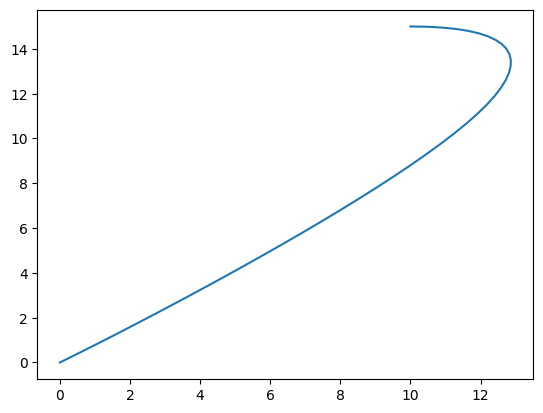

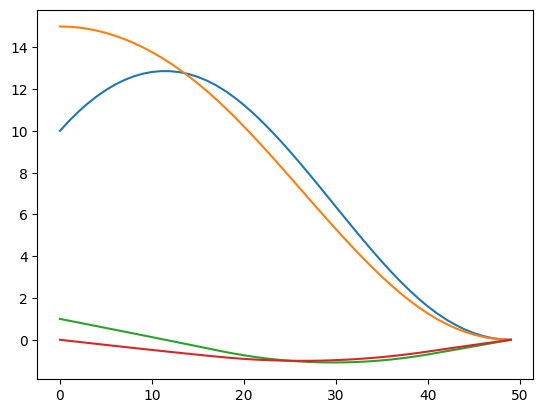

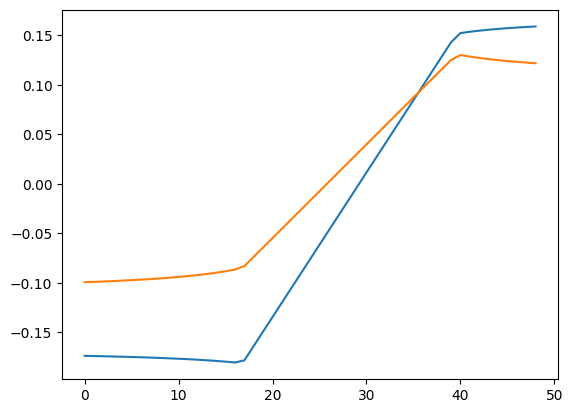

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f00e85dfc70>
 PyObject <matplotlib.lines.Line2D object at 0x7f00e85dfca0>

In [36]:
Xm = X.value
Um = U.value

figure()
plt.plot(Xm[1,:], Xm[2,:])

figure()
plt.plot(Xm')

figure()
plt.plot(Um')